# Final Project Extension 3
# Wooyoung Chung

In [1]:
import gym
import a3_gym_env
import sys
import torchvision
import torchvision.transforms as transforms
import cv2
import torch
from torch.optim import Adam
from torch.distributions.normal import Normal
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy
import matplotlib.pyplot as plt
# sample hyperparameters
batch_size = 10000
epochs = 30
learning_rate = 1e-2
hidden_size = 8
n_layers = 2
clipEpsilon = 0.2


/opt/homebrew/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE)
  Referenced from: '/opt/homebrew/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/opt/homebrew/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class PendulumNN(nn.Module):
    def __init__(self,input,output,activation=nn.Tanh):
        super(PendulumNN,self).__init__()
        self.conv1=nn.Conv2d(input,4,3)
        self.conv2=nn.Conv2d(4,4,3)
        self.conv3=nn.Conv2d(4,4,3)
        self.fc1=nn.Linear(2304,1000)
        self.fc2 = nn.Linear(1000,1)
        self.act1 = activation
        log_std = -0.5 * numpy.ones(output, dtype=numpy.float32)
        self.log_std = torch.nn.Parameter(torch.as_tensor(log_std))

    def forward(self,x):
        x= F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=F.relu(self.conv3(x))
        x=torch.reshape(x,(x.shape[0],2304))
        x= F.relu(self.fc1(x))
        x= self.fc2(x)
        vout = torch.exp(self.log_std)
        return x, vout

In [3]:
class PPOModels():
    def __init__(self,learningRate1,learningRate2):
        self.Actor = PendulumNN(2, 1)
        self.Critic = PendulumNN(2,1)
        self.optimActor = Adam(self.Actor.parameters(), lr=learningRate1)
        self.optimCritic = Adam(self.Critic.parameters(), lr=learningRate2)

    def saveModels(self):
        torch.save(self.Actor.state_dict(),"ActorModel.pt")
        torch.save(self.Critic.state_dict(),"CriticModel.pt")
        torch.save(self.optimActor.state_dict(),"optimActor.pt")
        torch.save(self.optimCritic.state_dict(),"optimCritic.pt")

In [4]:
def RewardsToGo(rewards,discountFactor):
    if len(rewards) == 1:
        return rewards
    RewardNext = RewardsToGo(rewards[1:],discountFactor)
    return [rewards[0]+(1-discountFactor)*RewardNext[0]]+RewardNext

In [5]:
def DoRollout(Models,rollout_size,episode_size,yes):
    obervations =[]
    rewards = []
    actions = []
    logprobs = []
    env=gym.make("Pendulum-v1-custom")
    for i in range(rollout_size):
        episodeRewards = []
        env.reset()
        obs = []
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),transforms.Grayscale()])
        img = env.render(mode='rgb_array')
        obs += (transform(img).tolist())
        for j in range(1):
            env.step([0])
            img = env.render(mode='rgb_array')
            obs += (transform(img).tolist())
        for j in range(episode_size):
            # if i == 0 and yes ==1:
            #     env.render()
            out_mean,out_variance   = Models.Actor(torch.tensor([obs]))
            out_action_distribution = Normal(out_mean[0], out_variance)
            action                  = out_action_distribution.sample()
            obervations.append(obs)
            _, reward, done, info = env.step(action.detach().tolist())
            obs = obs[1:]
            img =env.render(mode='rgb_array')
            obs += (transform(img).tolist())
            logprob = out_action_distribution.log_prob(action.detach())
            episodeRewards.append(reward.tolist())
            actions.append(action.numpy())
            logprobs.append([logprob])
        rewards.append(episodeRewards)
    return torch.tensor(numpy.array(obervations)).float(),rewards,torch.tensor(numpy.array(actions)),torch.tensor(logprobs).squeeze()


In [6]:
def getRatio(model,observations,actions,old_logprobs):
    out_mean,out_variance = model.Actor(observations)
    dist = Normal(out_mean, out_variance)
    log_probs = dist.log_prob(actions).squeeze()
    return torch.exp(log_probs-old_logprobs)

In [7]:
def CalculateAdvantage(model,observations,RTG):
    V = model.Critic(observations)[0].detach().squeeze()
    Advantage = (torch.tensor(RTG)-V)
    return Advantage

def GeneralAdvantage(model,states,rewards,discountFactor):
    if len(rewards)==1:
        return torch.tensor(rewards[0])
    delta = 1-discountFactor

    Vt = model.Critic(torch.tensor([states[0].tolist()]))[0].detach().squeeze()
    VT = torch.pow(torch.tensor(delta),len(states)-1)*model.Critic(torch.tensor([states[0].tolist()]))[0].detach().squeeze()
    RTG = RewardsToGo(rewards[:len(states)-1],discountFactor)[0]
    return -Vt+RTG+VT

def CalculateGeneralAdvantage(model, obervations,rewards,discountFactor):
    GeneralAdv =[]
    for i in range(len(rewards)):
        obs = obervations[i*len(rewards[0]):(i+1)*len(rewards[0])]
        for j in range(len(rewards[0])):
            GeneralAdv.append(GeneralAdvantage(model,obs[j:],rewards[i][j:],discountFactor))
    return torch.tensor(GeneralAdv)

In [8]:
def PPO(AdvantageType,UsingClip,batchSize,model,rollout=10,episodes =200,clipEpsilon=0.2,df = 0.01):
    batch_size = batchSize
    rollout_size = rollout
    episode_size= episodes
    epsilon= clipEpsilon
    discountFactor = df
    policy = model
    rtg_list = []
    actorGrad_loss_list = []
    criticGrad_loss_list = []
    iter_count = 1
    
    for i in range(batch_size):
        yes = 0
        # if i%100 == 0:
        #     yes = 1
        observations,rewards,actions,logprobs = DoRollout(policy,rollout_size,episode_size,yes)
        RTG = []
        for j in range(rollout_size):
            RTG+=RewardsToGo(rewards[j],discountFactor) 
        if AdvantageType=="RTG":
            Advantage = CalculateAdvantage(policy,observations,RTG)
        elif AdvantageType=="GAE":
            Advantage = CalculateGeneralAdvantage(policy,observations,rewards,discountFactor)
        else:
            return "ERROR NO ADV TYPE SPECIFIED"
        iter_count += 1
        rtg_list.append(sum(RTG)/rollout_size)
        if i%100 == 0:
            print(i)
            print(sum(RTG))
        for j in range(5):
            ratio = getRatio(policy,observations,actions,logprobs)
            if UsingClip == 1:
                reg =  Advantage*ratio
                clip = torch.clip(ratio, 1 - epsilon, 1 + epsilon) * Advantage
                actorGrad =(-torch.min(reg, clip)).mean()
            else:
                actorGrad = (-(Advantage*ratio)).mean()
            policy.optimActor.zero_grad()
            actorGrad.backward(retain_graph=True)
            policy.optimActor.step()

            V = policy.Critic(observations)[0].squeeze()
            criticGrad = nn.MSELoss()(V, torch.tensor(RTG))
            policy.optimCritic.zero_grad()
            criticGrad.backward()
            policy.optimCritic.step()
            
            if j ==4:
                actorGrad_loss_list.append(actorGrad.item())
                criticGrad_loss_list.append(criticGrad.item())
        policy.saveModels() 

    policy.saveModels()
    print("Saved!")
    return policy, rtg_list, actorGrad_loss_list, criticGrad_loss_list, rewards


In [9]:
def TryModel(model):
    env=gym.make("Pendulum-v1-custom")
    obs = env.reset()
    thetaLst = [np.arccos(obs[0])]
    thetaDotLst = [obs[2]]
    imgs = []
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),transforms.Grayscale()])
    img = env.render(mode='rgb_array')
    imgs += (transform(img).tolist())
    for i in range(1):
        env.step([0])
        img = env.render(mode='rgb_array')
        imgs += (transform(img).tolist())
    for i in range(200):
        action,_   = model.Actor(torch.tensor([imgs]))
        x = action.detach().tolist()
        obs, reward, done, info = env.step(x[0])
        imgs = imgs[1:]
        img =env.render(mode='rgb_array')
        imgs += (transform(img).tolist())
        thetaLst.append(np.arccos(obs[0]))
        thetaDotLst.append(obs[2])
    return thetaLst, thetaDotLst

In [10]:
def Environment(AdvantageType,Clip,batch_size,Rollout=10,episodes =200,clipEpsilon=0.2,df = 0.01,lr1=1e-2,lr2=1e-2):
    Model = PPOModels(lr1,lr2)
    return PPO(AdvantageType,Clip,batch_size,Model,Rollout,episodes,clipEpsilon,df)

In [11]:
def SeeForMyself(model):
    env=gym.make("Pendulum-v1-custom")
    obs = env.reset()
    imgs = []
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),transforms.Grayscale()])
    img = env.render(mode='rgb_array')
    imgs += (transform(img).tolist())
    for i in range(1):
        env.step([0])
        img = env.render(mode='rgb_array')
        imgs += (transform(img).tolist())
    for i in range(200):
        env.render()
        action,_   = model.Actor(torch.tensor([imgs]))
        env.step(action.detach().tolist()[0])
        imgs = imgs[1:]
        img =env.render(mode='rgb_array')
        imgs += (transform(img).tolist())
    return

# Extension3:
Use images instead of state vectors. Note that since you won't have 
access to velocity, you will need either to stack a few last images or to use a recurrent policy.

Clip 0.2, GAE, 4000 iterations, 10 rollout, 200 trajectoy length, discount factor 0.01, lr 0.00005, kernel size 3

In [12]:
model, rtg_list, actorGrad_loss_list, criticGrad_loss_list, rewards = Environment("GAE",1,4000,10,200,0.2,0.01,0.00005,0.00005)


0
-692683.724745721
100
-806215.073395129
200
-794089.9829791443
300
-796716.9390136006
400
-748801.0563320814
500
-677753.8030617471
600
-738932.6901037152
700
-765741.6628384241
800
-672685.4672420125
900
-656737.7493056633
1000
-679377.708410598
1100
-675049.1805624272
1200
-703329.8963043344
1300
-719831.3105443299
1400
-651227.6312655422
1500
-617630.9967596418
1600
-615979.2851392945
1700
-577255.9477188481
1800
-539442.5566774867
1900
-565290.969057956
2000
-553522.2223275199
2100
-484308.19835149567
2200
-516802.6887721205
2300
-485349.5683618836
2400
-493625.6766187288
2500
-506945.41230038705
2600
-448953.45659918524
2700
-469557.2936731829
2800
-503266.40380929195
2900
-470245.1754867986
3000
-442924.71058422176
3100
-435677.5982764566
3200
-445856.5337984367
3300
-421617.500528312
3400
-431733.312972906
3500
-384338.37801206426
3600
-349924.76434272935
3700
-309429.45131931663
3800
-322682.2205687366
3900
-165643.86589111274
Saved!


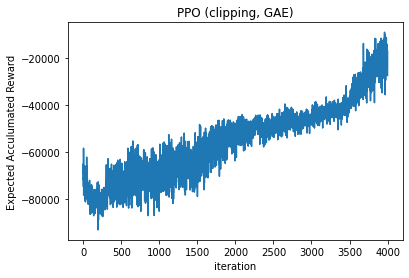

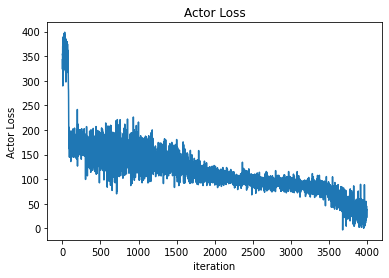

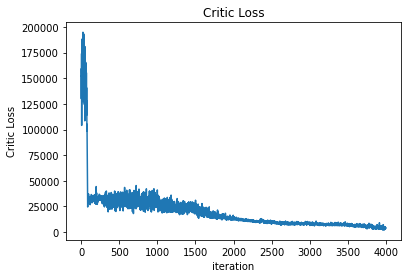

In [13]:
# plot rtg_list
plt.plot(rtg_list)
plt.title("PPO (clipping, GAE)")
plt.xlabel("iteration")
plt.ylabel("Expected Acculumated Reward")
plt.show()
# plot actorGrad_loss_list
plt.plot(actorGrad_loss_list)
plt.title("Actor Loss")
plt.xlabel("iteration")
plt.ylabel("Actor Loss")
plt.show()
# plot criticGrad_loss_list
plt.plot(criticGrad_loss_list)
plt.title("Critic Loss")
plt.xlabel("iteration")
plt.ylabel("Critic Loss")
plt.show()

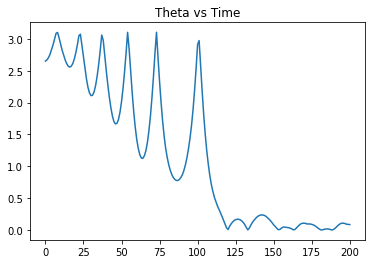

In [14]:
plts = TryModel(model)
plt.title("Theta vs Time")
plt.plot(plts[0])
plt.show()

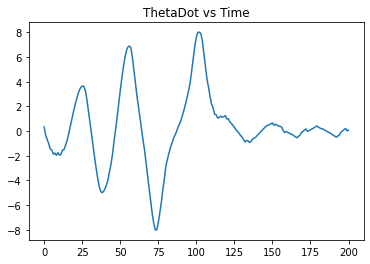

In [17]:
plt.title("ThetaDot vs Time")
plt.plot(plts[1])
plt.show()

# Discussion
In this extension, we attempted to train a policy for a swinging pendullum task using images. To do this, we had to stack multiple images per state to replace velocity. We also created our neural network using CNN

## The coding/optimization process
1) Stack size of the images: At first, the stack size of 5 was chosen; however, it was clearly shown that the model had hard time learning as well as the computation taking much,much longer. Rather, having the stack size of 2 was found to be the most optimal as there was less to "learn" due to having less images to learn from
2) Image size: Instead of having the default image size of 500x500, we trimmed down to 30x30. We chose this size as we wanted to balance between the images being too big (computationally expensive and will need to filter more) and being too small (we want to clearly spot the change in angles between current state and past state). We found 30x30 to be the sweet spot.
3) *Essential* Kernel size: Kernel size was found to be essential. We first used the kernel size of 2x2, but it was found having difficulty distinguishing the features of the different images. After using the kernel size of 3x3, the performance significantly increased.
4) *Essentail* CNN output size: The output size of the CNN must be big enough to process the two distinct images separatly to be able to learn that comparing the two images will extract the velocity needed to solve the problem. Having the output size of 2 was found to be too small and needed output size of 4 to learn properly
5) Epoch size: We found that a deep epoche size was not necessary in optimization. Instead, we chose to reduce the epoch size from 30 to 5 to save on computation.

## General Analysis:
From our experiment, our model was able to successfully balance a pendulum. However, a little more than 4k iterations is needed to truly learn optimally. The model took much longer to train (12 hours) compared to HW3. A lot more iteration was needed to train too. 